/var/folders/lc/2622zhjs0c5_29x1zxgbkg3r0000gn/T/ipykernel_930/2171307684.py:19: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead.
  G_ = ox.graph_from_bbox(north, south, east, west, network_type='drive', simplify=True).to_undirected()


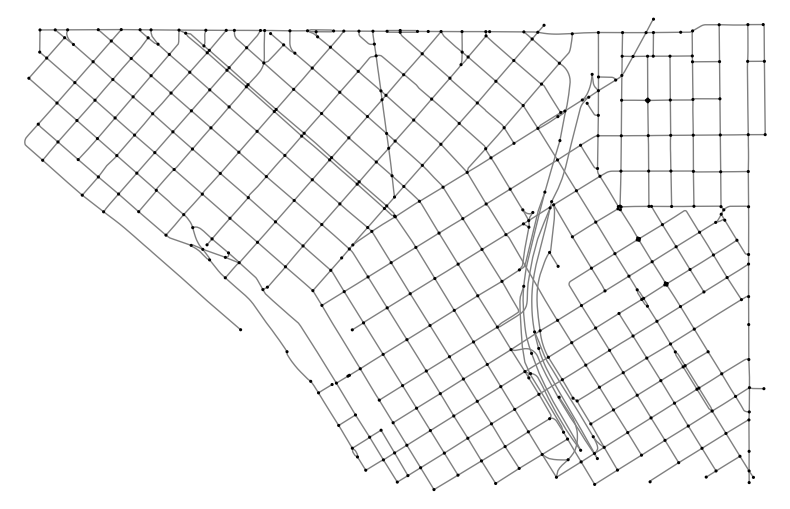

In [1]:
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
# cf = '["highway"~"motorway|motorway_link|primary"]'
cf = '["highway"~"motorway"]'

node_color = 'black'
edge_color = 'gray'

Coordinates = {'Boston': [42.367, 42.348, -71.051, -71.077], 'Chicago': [41.910, 41.887, -87.61, -87.640], 'Seattle': [47.619, 47.604, -122.320, -122.355], 'Washington DC': [38.906, 38.888, -77.000, -77.027], 'Manhattan, NYC': [40.790, 40.760, -73.970, -74.010], 'Miami': [25.787, 25.765, -80.187, -80.210] }
cities = ['Boston', 'Chicago', 'Seattle', 'Washington DC', 'Manhattan, NYC', 'Miami']


city = 'Seattle'


north, south, east, west = Coordinates[city]  
G_ = ox.graph_from_bbox(north, south, east, west, network_type='drive', simplify=True).to_undirected()


# Plot the graph using osmnx
ox.plot_graph(G_, node_color='black', edge_color='gray', node_size=5, bgcolor='white', show=False)


plt.tight_layout()
plt.show()

# fig.savefig('../JINT/images/all_cities.eps', bbox_inches ='tight', transparent=True )


In [2]:
# Relabel Nodes
relabelMap = {value: index for index, value in enumerate(G_.nodes())}

G = nx.relabel_nodes(G_,relabelMap)



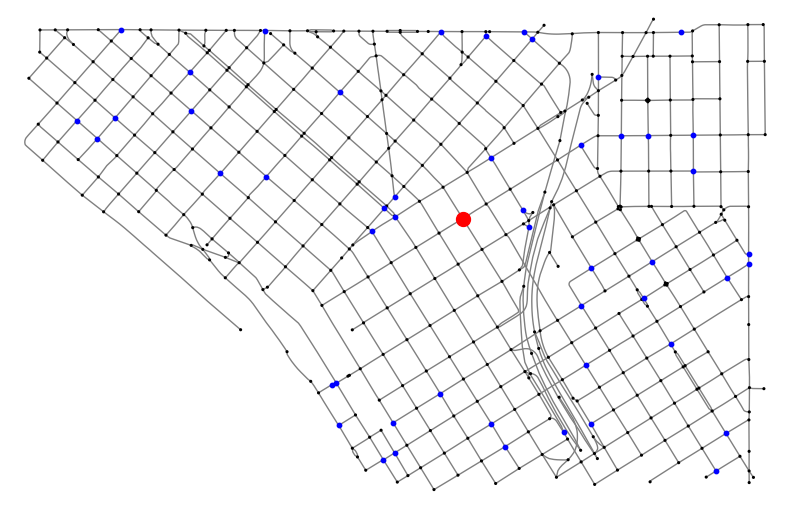

In [3]:
import numpy as np
import random


relabelMap = {index: value for index, value in enumerate(G.nodes())}



coordinates = {node: [data['x'], data['y']] for node, data in G.nodes(data = True)}

centroid = np.mean([ value for key, value in coordinates.items() ], axis=0)

distances_to_centroid = {node: np.linalg.norm(coord - centroid) for node, coord in coordinates.items()}

sorted_nodes = [node for node, _ in dict(sorted(distances_to_centroid.items(), key = lambda item: item[1])).items()]

depot = sorted_nodes[0]

targets = random.sample(sorted_nodes, k = 50)


fig, ax = ox.plot_graph(G, node_color='black', edge_color='gray', node_size=5, bgcolor='white', show=False, close=False)

# Plot the depot with a different color
depot_x, depot_y = coordinates[depot]
ax.scatter(depot_x, depot_y, c='red', s=100, zorder=5)

# Plot the targets with a different color
target_x, target_y = zip(*[coordinates[target] for target in targets])
ax.scatter(target_x, target_y, c='blue', s=10, zorder=5)

plt.tight_layout()
plt.show()

In [4]:
print(depot)

309


[310, 52, 239, 240] [310, 52, 239] [52, 239, 240]
[(240, 38), (240, 53), (240, 193), (240, 239)]


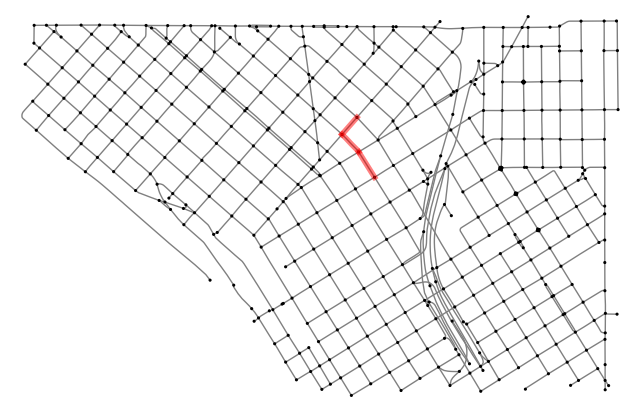

In [95]:
shortest_path = nx.shortest_path(G, source=310, target=240, weight='length')
# ox.plot_graph_route(G, shortest_path, node_size=5, node_color='black', edge_color='gray', bgcolor='white')
fig, ax = ox.plot_graph(G, node_color='black', edge_color='gray', node_size=5, bgcolor='white', show=False, close=False)
print(shortest_path, shortest_path[:-1], shortest_path[1:])
for (i, j) in zip(shortest_path[:-1], shortest_path[1:]):
    ox.plot_graph_route(G, [i, j], ax=ax, orig_dest_size=1, node_size=5, node_color='black', edge_color='gray', bgcolor='white', show=False, close=False)
print(G.edges(240))

In [11]:
all_nodes = [depot] + targets
distance_matrix = {} 
for i in range(len(all_nodes)-1):
    for j in range(i+1, len(all_nodes)):
        distance_matrix[(all_nodes[i],all_nodes[j])] = nx.shortest_path_length(G, source=all_nodes[i], target=all_nodes[j], weight='length')

In [25]:
import os 

output_directory = '../../../../data/'

os.makedirs(output_directory, exist_ok=True)

node_coordinates = {node: coordinates[node] for node in all_nodes}

with open(os.path.join(output_directory, 'seattle.tsp'), 'w') as graph_file:

    graph_file.write("NAME: seattle50\n")
    graph_file.write("DEPOT : 1\n")
    graph_file.write("COMMENT: Depot and 50 random targets in Seattle \n")
    graph_file.write(f"DIMENSION: {len(node_coordinates)}\n")
    graph_file.write("EDGE_WEIGHT_TYPE : GIVEN\n")
    graph_file.write("NODE_COORD_SECTION\n")

    for node, coord in node_coordinates.items():
        graph_file.write(f"{node} {coord[0]} {coord[1]}\n")

    graph_file.write("EDGE COSTS\n")

    for edge, dist in distance_matrix.items():
        graph_file.write(f"{edge[0]} {edge[1]} {dist}\n")

    graph_file.write("EOF\n")

# v1 = 53213825 v2 = 30345463

r
b
g


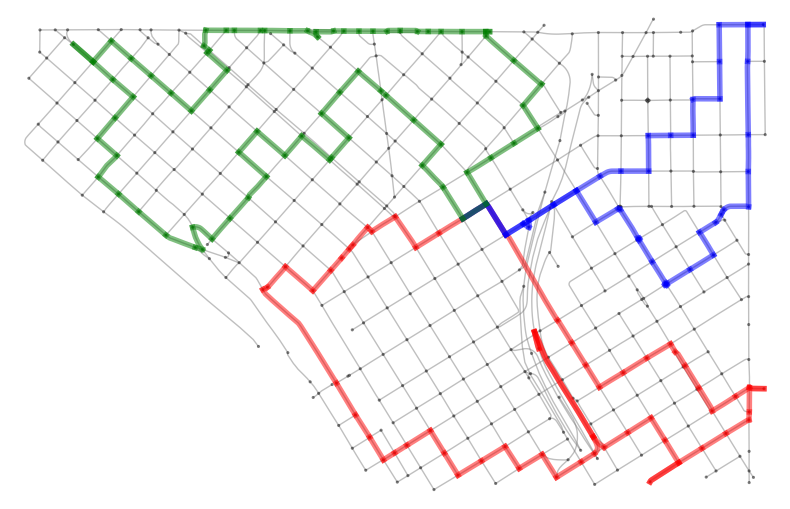

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import json 
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx

instanceName = 'seattle'
numVehicle = 3
objType = 'fair'
file = '../../../../logs/'+instanceName+'-v-'+str(numVehicle)+'-'+objType+'.json'

data = {}
with open(file, 'r') as jsonfile:
    data = json.load(jsonfile)

numVertices = data['numVertices']
numVehicles = data['numVehicles']
vertexCoords = data['vertexCoords']
tours = data['tours']
depot = data['depot']

vehicleColors = ['r','b','g']
allVehiclePath = []

fig, ax = ox.plot_graph(G, node_color='black', node_alpha = 0.5, edge_alpha = 0.5, edge_color='gray', node_size=5, bgcolor='white', show=False, close=False)

for vehicle in range(numVehicle):
    vehiclePath = []
    tour = tours[vehicle]
   
    for i in range(len(tour)-1):
        vehiclePath.extend(nx.shortest_path(G, source=tour[i], target=tour[i+1], weight='length')[:-1])
    vehiclePath.extend([tour[0]])

    color = vehicleColors[vehicle]
    for (i, j) in zip(vehiclePath[:-1], vehiclePath[1:]):
        ox.plot_graph_route(G, [i, j], route_color=color, ax=ax, orig_dest_size=1, node_size=5, node_color='black', edge_color='gray', bgcolor='white', show=False, close=False)

    allVehiclePath.append(vehiclePath)


plt.tight_layout()
plt.show()